In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_loader import calculate_rsi, get_data, get_fast_data
from backtest import evaluate_condition, vectorized_evaluate_condition, evaluate_strategy, vectorized_evaluate_strategy, backtest, fast_backtest
from grammar import grammar
from grammatical_evolution import map_genotype_to_fenotype
from selections import roulette_selection, tournament_selection
from crossovers import one_point_crossover
from mutations import random_mutation

### RSI

RSI - wskaźnik momentum, który mierzy szybkość i zmianę ruchów cenowych.
Range - 0 do 100

$$
RSI = 100 - \frac{100}{1 + RS}
$$

Gdzie

$$
RS = \frac{\text{Average Gain}}{\text{Average Loss}}
$$

In [3]:
def evolution(population_size, chromosome_size, crossover_probability, mutation_probability, number_of_iterations, number_of_offspring, data, grammar, initial_cash, max_depth, selection, crossover=None, mutation=None):
    best_objective_value = -np.inf
    best_chromosome = None
    best_rule = None
    current_population = np.random.randint(256, size=(population_size, chromosome_size))
    objective_values = np.zeros(population_size)
    for _ in range(number_of_iterations):
        # evaluating the objective function on the current population
        objective_values = np.zeros(population_size)
        for i, genotype in enumerate(current_population):
            rule = map_genotype_to_fenotype(genotype, grammar, max_depth)
            if rule is None:
                objective_values[i] = -100.0 * initial_cash
            else:
                try:
                    score = backtest(rule, data, initial_cash)
                    objective_values[i] = score
                except:
                    objective_values[i] = -100.0 * initial_cash
        
        # update best chromosome
        current_best = np.max(objective_values)
        if current_best > best_objective_value:
            best_idx = np.argmax(objective_values)
            best_chromosome = current_population[best_idx].copy()
            best_objective_value = current_best
            best_rule = map_genotype_to_fenotype(best_chromosome, grammar, max_depth)
            print(f"Znaleziono nowy najlepszy wynik: {current_best}, rule = {best_rule}")
        
        # selecting the parent indices by the roulette wheel method
        parents = selection(objective_values, current_population, number_of_offspring)

        # crossover
        offspring = np.zeros((number_of_offspring, chromosome_size), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            p1 = parents[2*i].copy()
            p2 = parents[2*i+1].copy()

            if crossover and np.random.random() < crossover_probability:
                offspring[2*i, :], offspring[2*i+1, :] = crossover(p1, p2)
            else:
                offspring[2*i, :], offspring[2*i+1, :] = p1, p2
        if np.mod(number_of_offspring, 2) == 1:
            offspring[-1, :] = current_population[0, :]

        # mutation
        if mutation:
            for i in range(number_of_offspring):
                if np.random.random() < mutation_probability:
                    offspring[i, :] = mutation(offspring[i, :])
        
        current_population = offspring
    
    return best_chromosome, best_objective_value, best_rule

In [4]:
def fast_evolution(population_size, chromosome_size, crossover_probability, mutation_probability, number_of_iterations, number_of_offspring, data, grammar, initial_cash, max_depth, selection, crossover=None, mutation=None):
    best_objective_value = -np.inf
    best_chromosome = None
    best_rule = None
    current_population = np.random.randint(256, size=(population_size, chromosome_size))
    objective_values = np.zeros(population_size)
    for _ in range(number_of_iterations):
        # evaluating the objective function on the current population
        objective_values = np.zeros(population_size)
        for i, genotype in enumerate(current_population):
            rule = map_genotype_to_fenotype(genotype, grammar, max_depth)
            if rule is None:
                objective_values[i] = -100.0 * initial_cash
            else:
                try:
                    score = fast_backtest(rule, data, initial_cash)
                    objective_values[i] = score
                except:
                    objective_values[i] = -100.0 * initial_cash
        
        # update best chromosome
        current_best = np.max(objective_values)
        if current_best > best_objective_value:
            best_idx = np.argmax(objective_values)
            best_chromosome = current_population[best_idx].copy()
            best_objective_value = current_best
            best_rule = map_genotype_to_fenotype(best_chromosome, grammar, max_depth)
            print(f"Znaleziono nowy najlepszy wynik: {current_best}, rule = {best_rule}")
        
        parents = selection(objective_values, current_population, number_of_offspring)

        # creating offspring
        offspring = np.zeros((number_of_offspring, chromosome_size), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            p1 = parents[2*i].copy()
            p2 = parents[2*i+1].copy()

            if crossover and np.random.random() < crossover_probability:
                offspring[2*i, :], offspring[2*i+1, :] = crossover(p1, p2)
            else:
                offspring[2*i, :], offspring[2*i+1, :] = p1, p2
        if np.mod(number_of_offspring, 2) == 1:
            offspring[-1, :] = current_population[0, :]

        # mutation
        if mutation:
            for i in range(number_of_offspring):
                if np.random.random() < mutation_probability:
                    offspring[i, :] = mutation(offspring[i, :])
        
        current_population = offspring
    
    return best_chromosome, best_objective_value, best_rule

In [5]:
print(grammar)

{'<start>': [['IF', '<cond>', 'THEN', '<strategy>', 'ELSE', '<strategy>']], '<strategy>': [['IF', '<cond>', 'THEN', '<strategy>', 'ELSE', '<strategy>'], ['<action>']], '<cond>': [['<expr>', '<op>', '<expr>'], ['<cond>', 'AND', '<cond>'], ['<cond>', 'OR', '<cond>']], '<expr>': ['Close', 'SMA10', 'SMA50', 'RSI', '<const>'], '<op>': ['>', '<', '>=', '<=', '=='], '<action>': ['BUY', 'SELL', 'HOLD'], '<const>': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [10]:
print(fast_evolution(1000, 50, 0.8, 0.15, 100, 1000, get_fast_data('MSFT'), grammar, 1000, 10, selection=roulette_selection, crossover=one_point_crossover, mutation=random_mutation))

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2460.7442663522006, rule = {'type': 'if', 'condition': {'left': 70, 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
(array([112, 186,  84, 236, 106, 213, 133,  88, 229,  96, 130, 176, 205,
       163, 211,  21, 255, 197, 229,  31, 118, 186,  46, 164,  62,  21,
         6, 102, 173, 100,  19,  49, 203, 126, 141, 128, 109,   0,  59,
       164, 138, 176, 210, 110,  37,  63,  58, 126,  44,  80]), np.float64(2460.7442663522006), {'type': 'if', 'condition': {'left': 70, 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}})


In [11]:
def compare_profit(ticker, population=500, chromosome_size=50, iterations=100, initial_cash=1000, max_depth=6, split_ratio=0.8, selection=roulette_selection):
    print(f"Running experiment on ticker: {ticker}\n")
    data_full = get_fast_data(ticker, start="2018-01-01", end="2025-01-01")

    n_total = len(data_full['Close'])
    split_idx = int(n_total * split_ratio)

    data_train = {key: val[:split_idx] for key, val in data_full.items()}
    data_test =  {key: val[split_idx:] for key, val in data_full.items()}

    print(f"Running evolution")

    _, _, best_rule = fast_evolution(population, chromosome_size, 0.8, 0.15, iterations, population, data_train, grammar, initial_cash, max_depth, selection=selection, crossover=one_point_crossover, mutation=random_mutation)

    print(f"Best rule found:\n{best_rule}\n")

    return_train = fast_backtest(best_rule, data_train, initial_cash)
    return_test = fast_backtest(best_rule, data_test, initial_cash)

    train_prices = data_train['Close']
    bh_return_train = ((initial_cash / train_prices[0]) * train_prices[-1]) - initial_cash
    
    test_prices = data_test['Close']
    bh_return_test = ((initial_cash / test_prices[0]) * test_prices[-1]) - initial_cash

    print(f"Algorytm na danych treningowych zarobił: {return_train}")
    print(f"Buy and hold na danych treningowych zarobiło: {bh_return_train}")
    print(f"Algorytm na danych testowych zarobił: {return_test}")
    print(f"Buy and hold na danych testowych zarobiło: {bh_return_test}")


In [13]:
compare_profit('AAPL', selection=roulette_selection)

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: AAPL

Running evolution
Znaleziono nowy najlepszy wynik: 3409.4527139017455, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


Znaleziono nowy najlepszy wynik: 3482.9909679662496, rule = {'type': 'if', 'condition': {'left': 50, 'op': '<', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 3791.3463186530053, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Best rule found:
{'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}

Algorytm na danych treningowych zarobił: 3791.3463186530053
Buy and hold na danych treningowych zarobiło: 3146.0

In [14]:
def compare_profits(tickers, population=500, chromosome_size=50, iterations=100, initial_cash=1000, max_depth=6, split_ratio=0.8, selection=roulette_selection):
    res = []
    print(f"Running experiment on ticker: {tickers}\n")

    for ticker in tickers:
        data_full = get_fast_data(ticker, start="2018-01-01", end="2025-01-01")

        n_total = len(data_full['Close'])
        split_idx = int(n_total * split_ratio)

        data_train = {key: val[:split_idx] for key, val in data_full.items()}
        data_test =  {key: val[split_idx:] for key, val in data_full.items()}

        _, _, best_rule = fast_evolution(population, chromosome_size, 0.8, 0.15, iterations, population, data_train, grammar, initial_cash, max_depth, selection=selection, crossover=one_point_crossover, mutation=random_mutation)

        return_train = fast_backtest(best_rule, data_train, initial_cash)
        return_test = fast_backtest(best_rule, data_test, initial_cash)

        train_prices = data_train['Close']
        bh_return_train = ((initial_cash / train_prices[0]) * train_prices[-1]) - initial_cash
        
        test_prices = data_test['Close']
        bh_return_test = ((initial_cash / test_prices[0]) * test_prices[-1]) - initial_cash

        res.append({
                'ticker': ticker,
                'train': return_train,
                'bh_train': bh_return_train,
                'test': return_test,
                'bh_test': bh_return_test
            })
        
    return pd.DataFrame(res)

In [15]:
def plot_portfolio_comparison(df_results):
    tickers = df_results['ticker']
    x = np.arange(len(tickers))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    rects1 = ax1.bar(x - width/2, df_results['train'], width, label='Strategia ewolucyjna', color='forestgreen')
    rects2 = ax1.bar(x + width/2, df_results['bh_train'], width, label='Buy & Hold', color='lightgray', edgecolor='black')

    ax1.set_title('Wyniki na zbiorze treningowym', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Zysk (USD)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(tickers)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    rects3 = ax2.bar(x - width/2, df_results['test'], width, label='Strategia ewolucyjna', color='royalblue')
    rects4 = ax2.bar(x + width/2, df_results['bh_test'], width, label='Buy & Hold', color='lightgray', edgecolor='black')

    ax2.set_title('Wyniki na Zbiorze TESTOWYM (Weryfikacja)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Zysk (USD)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(tickers)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Dodanie linii zero (żeby widzieć straty)
    ax1.axhline(0, color='black', linewidth=0.8)
    ax2.axhline(0, color='black', linewidth=0.8)

    # Dodanie wartości nad słupkami (opcjonalne, dla czytelności)
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)
    autolabel(rects3, ax2)
    autolabel(rects4, ax2)

    plt.tight_layout()
    plt.show()

Running experiment on ticker: ['MSFT', 'GOOGL', 'TSLA', 'PTON', 'NVDA', 'AMD']



[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2649.7098915577176, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2831.808001087691, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2157.8659043512603, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2180.786702482193, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '==', 'right': 'SMA10'}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 21711.800918751786, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 895.5090166214077, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>=', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 9546.198222215913, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 20}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}}
Znaleziono nowy najlepszy wynik: 9834.826984029633, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 20}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 'SMA10', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 9843.687994443844, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 13262.061497787345, rule = {'type': 'if', 'condition': {'left': 80, 'op': '<=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 14942.96184082514, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 80}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}


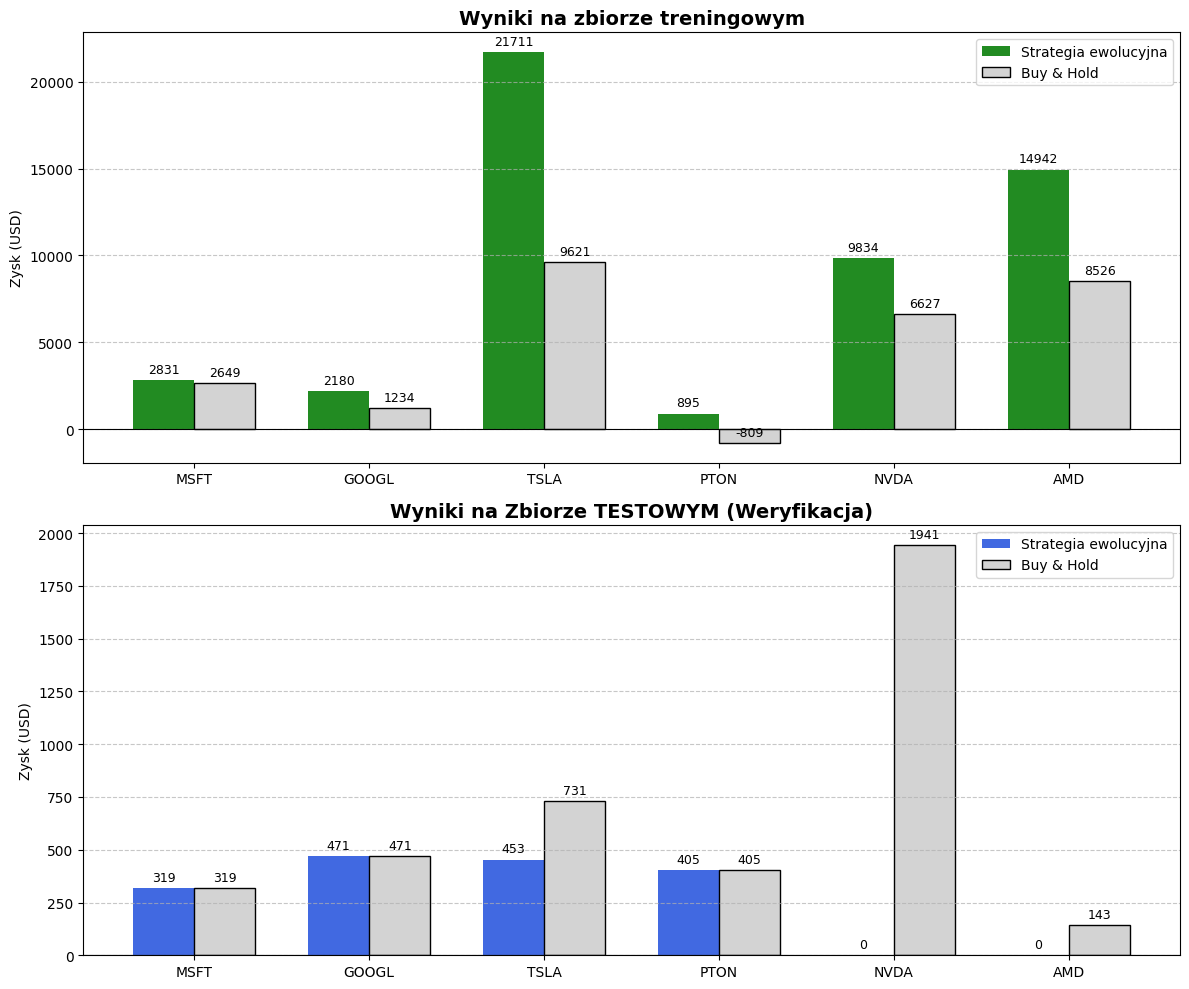

In [16]:
plot_portfolio_comparison(compare_profits(['MSFT', 'GOOGL', 'TSLA', 'PTON', 'NVDA', 'AMD']))

Jak widać gdy funkcją celu jest zwykła maksymalizacja zysku, algorytm bardzo overfituje na dane treningowe

[*********************100%***********************]  1 of 1 completed

Running experiment on ticker: ['MSFT', 'GOOGL', 'TSLA', 'PTON', 'NVDA', 'AMD']

Znaleziono nowy najlepszy wynik: 2649.7098915577176, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA50', 'op': '>=', 'right': 'SMA50'}, 'logic_op': 'OR', 'right': {'left': 'Close', 'op': '>', 'right': 10}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'BUY'}}
Znaleziono nowy najlepszy wynik: 2831.808001087691, rule = {'type': 'if', 'condition': {'left': 'SMA10', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}



[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 2180.786702482193, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': {'left': 100, 'op': '>=', 'right': 20}, 'logic_op': 'OR', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'SMA10'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 2264.6336891770957, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'if', 'condition': {'left': {'left': 100, 'op': '>=', 'right': 20}, 'logic_op': 'AND', 'right': {'left': 'SMA10', 'op': '<=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'BUY'}}}
Znaleziono nowy najlepszy wynik: 2488.7682773725865, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'SMA50'}, 'then': 

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 17198.60433769976, rule = {'type': 'if', 'condition': {'left': 10, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}


[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 0.0, rule = {'type': 'if', 'condition': {'left': 'RSI', 'op': '<', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'SELL'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 298.791562707356, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '<', 'right': 60}, 'logic_op': 'AND', 'right': {'left': 30, 'op': '>', 'right': 'RSI'}}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action', 'value': 'BUY'}}, 'else': {'type': 'action', 'value': 'SELL'}}
Znaleziono nowy najlepszy wynik: 511.2158709179639, rule = {'type': 'if', 'condition': {'left': {'left': 'SMA10', 'op': '<', 'right': 50}, 'logic_op': 'AND', 'right': {'left': 30, 'op': '>', 'right': 'RSI'}}, 'then': {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<=', 'right': 'Close'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'action

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 7582.526879329507, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 70, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}}
Znaleziono nowy najlepszy wynik: 9611.090957051149, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 70, 'op': '>', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'SELL'}}}
Znaleziono nowy najlepszy wynik: 11631.37815095207, rule = {'type': 'if', 'condition': {'left': 'SMA50', 'op': '<', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'HOLD'}, 'else': {'type': 'if', 'condition': {'left': 70, 'op': '<=', 'right': 'RSI'}, 'then': {'type': 'action', 'value': 'BUY'}, 'els

[*********************100%***********************]  1 of 1 completed


Znaleziono nowy najlepszy wynik: 8526.408846068314, rule = {'type': 'if', 'condition': {'left': {'left': 'Close', 'op': '==', 'right': 'Close'}, 'logic_op': 'AND', 'right': {'left': 'Close', 'op': '<=', 'right': 'RSI'}}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 8802.536376326107, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>=', 'right': 'SMA50'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}
Znaleziono nowy najlepszy wynik: 9843.687994443844, rule = {'type': 'if', 'condition': {'left': 'Close', 'op': '>', 'right': 'SMA10'}, 'then': {'type': 'action', 'value': 'BUY'}, 'else': {'type': 'action', 'value': 'HOLD'}}


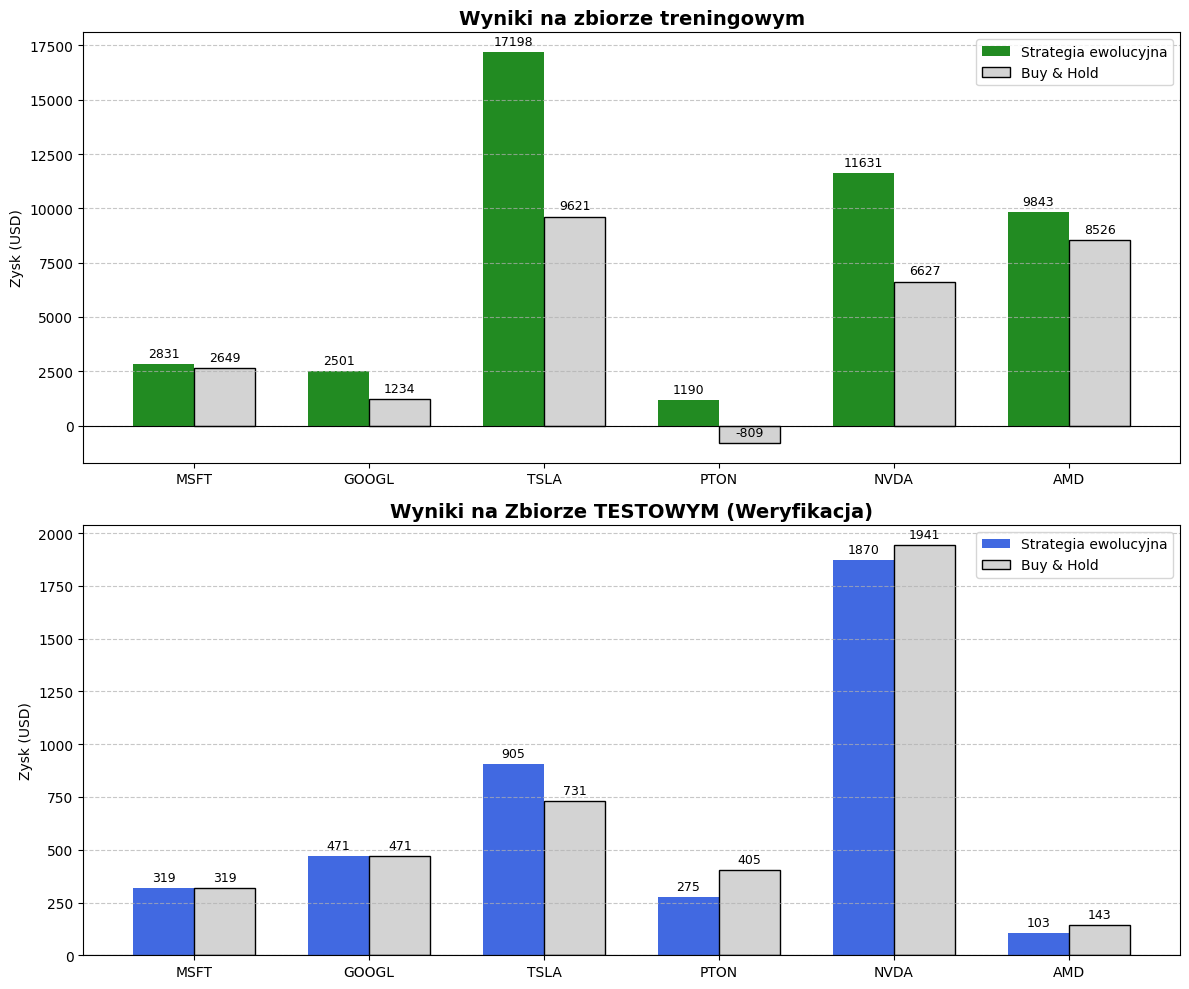

In [17]:
plot_portfolio_comparison(compare_profits(['MSFT', 'GOOGL', 'TSLA', 'PTON', 'NVDA', 'AMD'], selection=tournament_selection))